In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

In [2]:
#df = pd.read_csv("time_to_failure_data/timeToFailure-14_pc_res-c_max=5.00.csv").drop(columns=["failure_time.1"])
#df = df.drop(columns=["failure_time.1"])
#df

In [3]:
cmax_vals = [4.7, 4.8, 4.9, 5., 5.1] #values of c_max

In [4]:
def getListOfDataFramesForPCRes(pc_res, c_vals):
    '''gets a list containing the dataframes for each ttf simulation as a function of c_max for a specified % resistant'''
    
    df_list = []
    
    for cv in c_vals:
        #session 1
        df1 = pd.read_csv("time_to_failure_data/timeToFailure-"+str(pc_res)+"_pc_res-c_max="+"{:.2f}".format(cv)+".csv")
        #session 2
        df2 = pd.read_csv("time_to_failure_data/timeToFailure-"+str(pc_res)+"_pc_res-c_max="+"{:.2f}".format(cv)+"session-2.csv")
        
        df = pd.concat([df1, df2], ignore_index=True)
        df_list.append(df)
        
    return df_list

In [5]:
def survival_probability(ttf_data):
    '''takes in a dataframe and works out the survival probability as a function of time'''
    histo, bin_edges = np.histogram(ttf_data["failure_time"], bins=100)
    n_vals = len(ttf_data) #get number of runs
    survival_probs = (n_vals-np.cumsum(histo[1:]))/n_vals #get the survival probs (ignoring the 0 bin)
    survival_probs = np.append(1., survival_probs) #add the initial value of 1. for t = 0
    errs = (survival_probs*(1. - survival_probs))/np.sqrt(n_vals)
    #print(n_vals)
    #print(errs)
    #ignore the final value in surv_probs due to exit time being t_max by default
    return bin_edges[:-2], survival_probs[:-1], errs[:-1]

In [6]:
def plot_survival_probs(ttf_df_list, c_vals):
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    for ttf_d, c_val in zip(ttf_df_list, c_vals):
        
    #for ttf, pc_r in zip(collated_ttfs, pc_res_list):
        t, surv_prob, errs = survival_probability(ttf_d)
        #print(surv_prob)
    #print(surv_prob)
        ax.errorbar(t[:], surv_prob[:], yerr=errs[:], lw=2.2, label =  "$c_{\max} = $"+str(c_val))
        #ax.plot(t, surv_prob)
    
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    #ax.set_xlim(0, float(time_1yr))
    ax.set_ylim(0, 1.01)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize="large")
    #plt.legend(fontsize='large')
    plt.show()

In [7]:
ttf_14pcres = getListOfDataFramesForPCRes(14, cmax_vals)
ttf_15pcres = getListOfDataFramesForPCRes(15, cmax_vals)
ttf_16pcres = getListOfDataFramesForPCRes(16, cmax_vals)


In [8]:
# plot_survival_probs(ttf_14pcres, cmax_vals)
# plot_survival_probs(ttf_15pcres, cmax_vals)
# plot_survival_probs(ttf_16pcres, cmax_vals)

In [9]:
#def fit_survival_slopes

In [10]:
def fit_and_plot_survival_slope(ttf_df_list, cmax_vals):
    '''this function takes in the survival probability data and fits an exponential decay to it.  We can then extract the slope and plot this vs % resistant
    returns a list of tuples.  each tuple contains the % resistance of a population and its associated characteristic failure time tau'''
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        return a*np.exp(-b*x) #+ c
        #return a*x + b
        
    cmax_tau_and_err = [] #this is the list that the cmax vals, exponential slopes and the associated fit error will be saved to
    
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, c_max in zip(ttf_df_list, cmax_vals):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        
        popt, pcov = curve_fit(func, t[3:], surv_prob[3:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
        print(popt)
        print(fit_errs)
        print()
        
        cmax_tau_and_err.append((c_max, popt[1], fit_errs[1]))
        
        color=next(ax._get_lines.prop_cycler)['color']
        ax.plot(t, surv_prob, color=color, lw=2.2, label=str(c_max))
        ax.plot(t, func(t, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
        #print(popt)
        #print(pcov)
        
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize="large", title="c$_{\max}$")
    plt.rcParams['legend.title_fontsize'] = '14'
    #plt.savefig('plots/fitted_surv_probs.pdf')
    plt.show()
    
    return cmax_tau_and_err
        

In [11]:
def plot_characteristic_failure_rate(cmax_and_tau):
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    cmax, tau, tau_err = zip(*cmax_and_tau) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]
    print(tau)
    print(tau_err)
    print(tau_err_percent)
    print(tau_err_scaled)
    
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    print(tau_err_analytic)
    
    
    ax.errorbar(cmax, tau_scaled, yerr=tau_err_scaled, lw=2.2)
    ax.plot(cmax, tau_scaled, marker='h', ms=12, lw=2.2)
    
    ax.set_title('Failure characteristic vs c$_{\max}$', fontsize=titleSize)
    ax.set_xlabel('c$_{\max}$', fontsize=labelSize)
    ax.set_ylabel('time to failure (years)', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.semilogy()
    #plt.savefig('plots/failure_char_vs_pcres.pdf')
    plt.show()

In [12]:
def plot_fitSlopes_and_failRate(ttf_df_list, cmax_vals, filename):
    '''plots a 2x1 plot of the fitted survival probabilities and the time to failure vs c_max
    
    REBRAND THIS FOR THE PLOTS AS "SURVIVAL TIME", MAKES A BIT MORE SENSE.
    '''
    
    fig, axes = plt.subplots(1, 2, dpi=220)
    fig.set_size_inches(6,3)
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    nbins = 32
    
    cmax_tau_and_err = [] #this is the list that the cmax vals, exponential slopes and the associated fit error will be saved to
    
    # fit curves to the survival probability data
    ######################################
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        #return a*np.exp(-b*x) #+ c
        return np.exp(-b*x)
        #return a*x + b
        
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, c_max in zip(ttf_df_list, cmax_vals):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        t_scaled = np.array([t_val/(24.*365.) for t_val in t])
        
        popt, pcov = curve_fit(func, t_scaled[3:], surv_prob[3:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
        print(popt)
#         print(fit_errs)
#         print()
        
        cmax_tau_and_err.append((c_max, popt[1], fit_errs[1]))
        
        color=next(axes[0]._get_lines.prop_cycler)['color']
        axes[0].plot(t_scaled, surv_prob, color=color, lw=1.4, label=str(c_max))
        axes[0].plot(t_scaled, func(t_scaled, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
    axes[0].set_title('$p_s$ vs $t$', fontsize=titleSize)
    axes[0].set_xlabel('$t$ (years)', fontsize=labelSize, labelpad=-1)
    axes[0].set_ylabel('$p_s$', fontsize=labelSize, labelpad=0)
    axes[0].xaxis.set_tick_params(labelsize=numbersize)
    axes[0].yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = axes[0].get_legend_handles_labels()
    plt.rcParams['legend.title_fontsize'] = '10'
    axes[0].legend(handles[::-1], labels[::-1], fontsize="7", title="c$_{\max}$", framealpha=0.5)
    axes[0].text(0.87, 0.925, "(a)", transform=axes[0].transAxes, fontsize=12.8)
    plt.rcParams['legend.title_fontsize'] = '10'    
    
    
    
    
    
    
    
    cmax, tau, tau_err = zip(*cmax_tau_and_err) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]
#     print(tau)
#     print(tau_err)
#     print(tau_err_percent)
#     print(tau_err_scaled)
    
    ttf = [1./tau_val for tau_val in tau]
    #print(ttf)
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    tau_err_analytic_v2 = [(abs(1./t)*t_err/(abs(t))) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    #print(tau_err_analytic)
    
    color=next(axes[1]._get_lines.prop_cycler)['color']
    axes[1].errorbar(cmax, ttf, yerr=tau_err_analytic_v2, lw=2.2, color=color)
    axes[1].plot(cmax, ttf, marker='h', ms=6, lw=2.2, color=color)
    
    axes[1].set_title('$t_s$ vs $c_{\max}$', fontsize=titleSize)
    axes[1].set_xlabel('$c_{\max}$', fontsize=labelSize, labelpad=-1)
    axes[1].set_ylabel('$t_s$ (years)', fontsize=labelSize, labelpad=0)
    axes[1].xaxis.set_tick_params(labelsize=numbersize)
    axes[1].yaxis.set_tick_params(labelsize=numbersize)
    axes[1].semilogy()
    axes[1].text(0.01, 0.925, "(b)", transform=axes[1].transAxes, fontsize=12.8)
    #axes[1].tick_params(axis='both', which='major', pad=1)
    
    plt.subplots_adjust(wspace=0.3)
    plt.savefig("time_to_failure_plots/"+filename+".pdf", bbox_inches="tight")
    plt.show()
    
    return ttf
        #print(popt)
        #print(pcov)

[1.         4.28143477 1.        ]
[1.         1.50699203 1.        ]
[1.        0.4450253 1.       ]
[1.         0.13379713 1.        ]
[1.         0.02698833 1.        ]


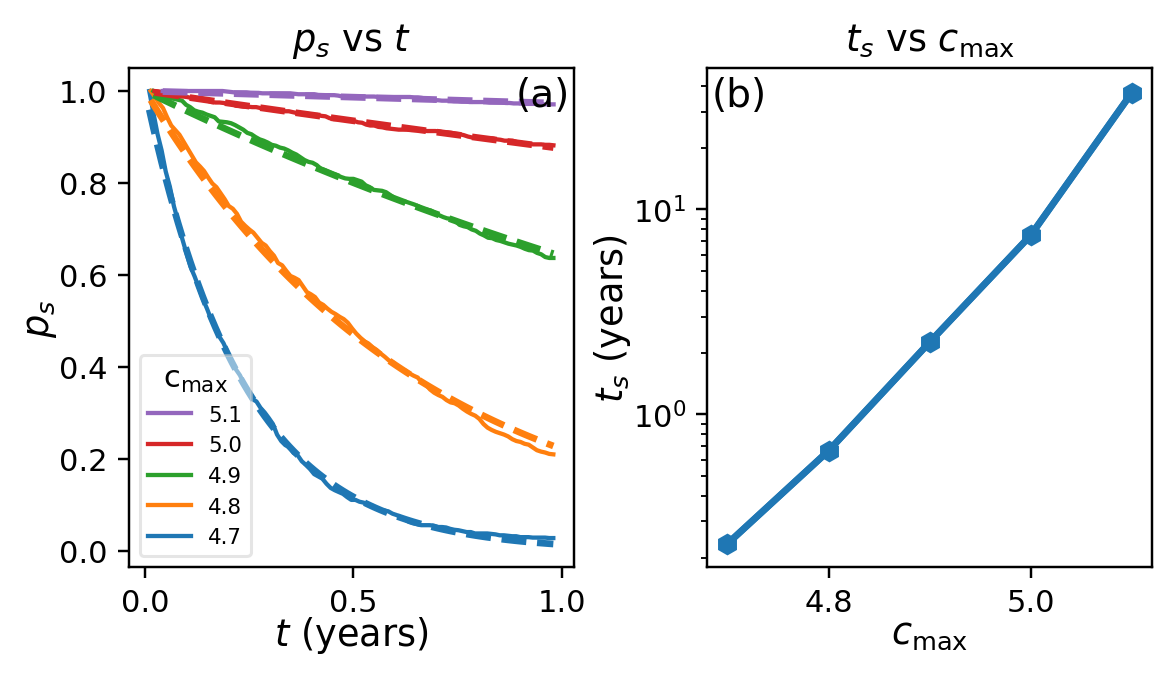

[1.        4.6313224 1.       ]
[1.         1.82097661 1.        ]
[1.         0.62402566 1.        ]
[1.         0.21556066 1.        ]
[1.         0.06383066 1.        ]


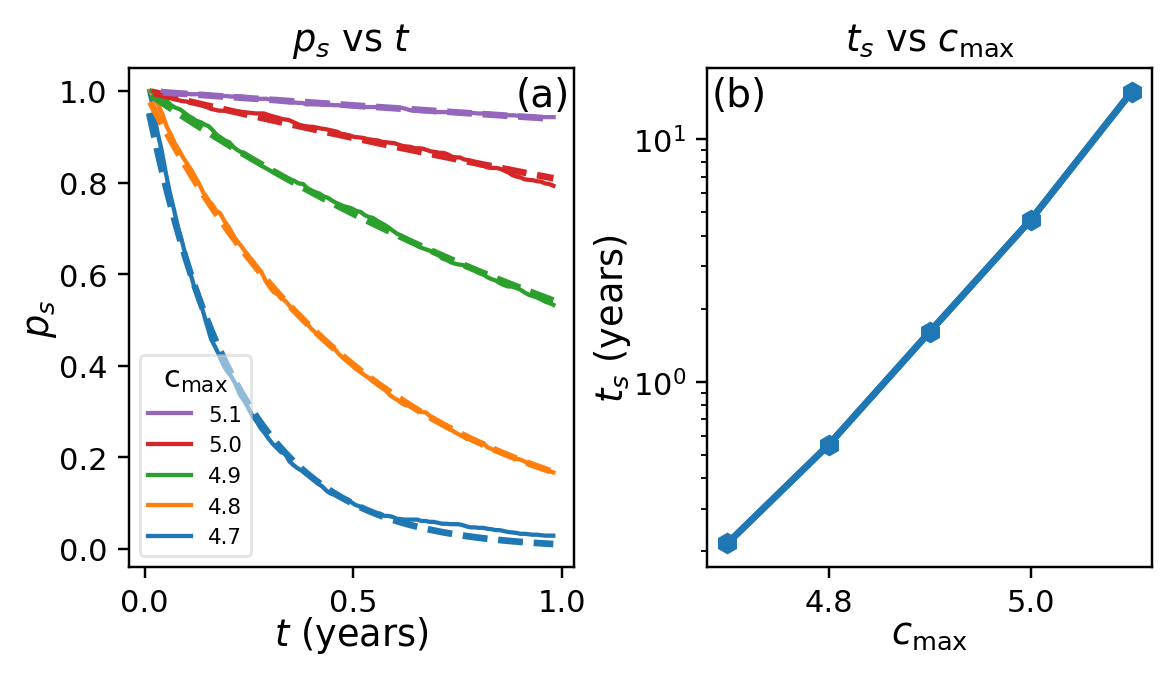

[1.         4.36611689 1.        ]
[1.         1.91708288 1.        ]
[1.         0.89706576 1.        ]
[1.         0.33513768 1.        ]
[1.         0.14583233 1.        ]


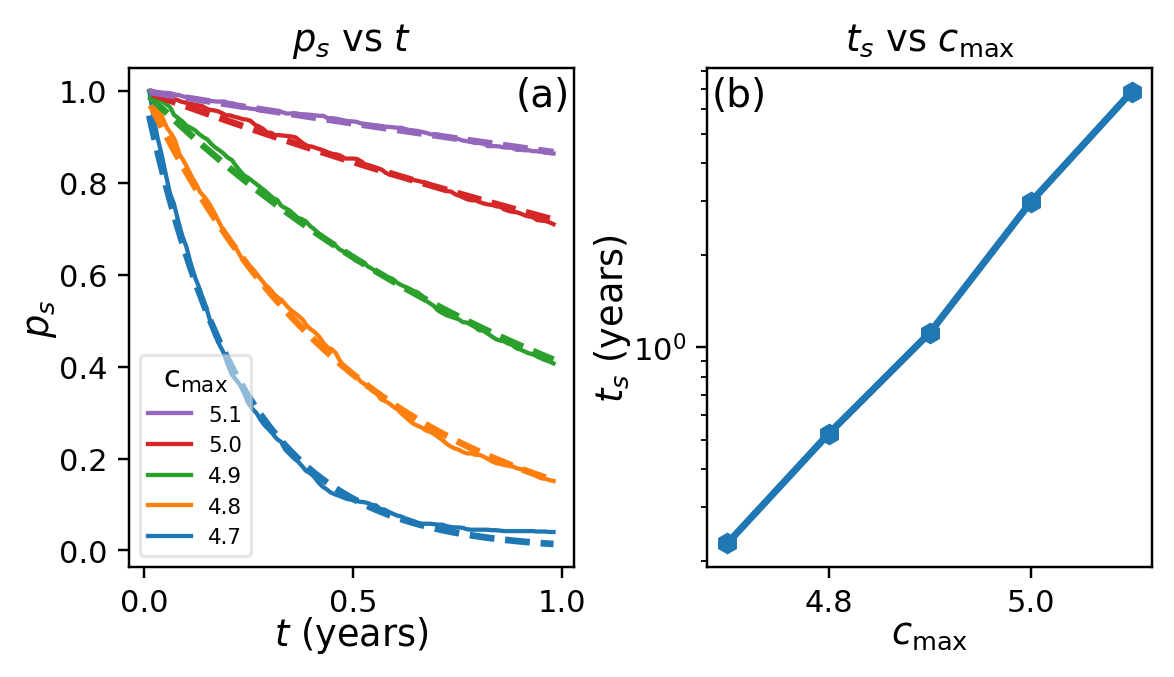

[0.2335665621055429, 0.6635735179117156, 2.24706324837704, 7.474002147338956, 37.05305399943186]


In [13]:
ttf_14pc = plot_fitSlopes_and_failRate(ttf_14pcres, cmax_vals, "ttf_plots_14pcres")
ttf_15pc = plot_fitSlopes_and_failRate(ttf_15pcres, cmax_vals, "ttf_plots_15pcres")
ttf_16pc = plot_fitSlopes_and_failRate(ttf_16pcres, cmax_vals, "ttf_plots_16pcres")
print(ttf_14pc)

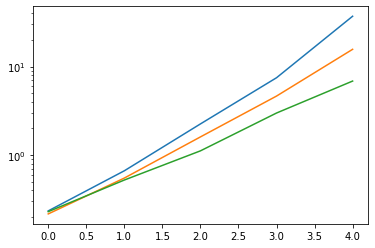

In [17]:
plt.plot(ttf_14pc)
plt.plot(ttf_15pc)
plt.plot(ttf_16pc)
plt.semilogy()
plt.show()

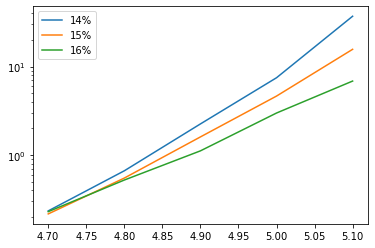

In [19]:
plt.plot(cmax_vals, ttf_14pc, label="14%")
plt.plot(cmax_vals, ttf_15pc, label="15%")
plt.plot(cmax_vals, ttf_16pc, label="16%")
plt.semilogy()
plt.legend()
plt.show()

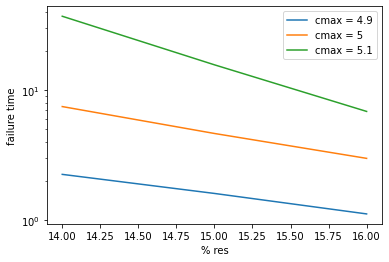

In [27]:
plt.plot([14, 15, 16], [ttf_14pc[-3], ttf_15pc[-3], ttf_16pc[-3]], label="cmax = 4.9")
plt.plot([14, 15, 16], [ttf_14pc[-2], ttf_15pc[-2], ttf_16pc[-2]], label="cmax = 5")
plt.plot([14, 15, 16], [ttf_14pc[-1], ttf_15pc[-1], ttf_16pc[-1]], label="cmax = 5.1")
plt.legend()
plt.semilogy()
plt.xlabel("% res")
plt.ylabel("failure time")
plt.show()
                         

[9.99999944e-01 4.88748183e-04 1.00000000e+00]
[4.05193224e-03 2.43221276e-06 0.00000000e+00]

[9.9999997e-01 1.7203030e-04 1.0000000e+00]
[4.50143737e-03 1.33066097e-06 0.00000000e+00]

[9.99999992e-01 5.08017959e-05 1.00000000e+00]
[2.35279058e-03 5.13460446e-07 0.00000000e+00]

[9.99999997e-01 1.52736112e-05 1.00000000e+00]
[5.66082641e-04 1.14315228e-07 0.00000000e+00]

[1.00000000e+00 3.08076301e-06 1.00000000e+00]
[6.91878079e-04 1.34877895e-07 0.00000000e+00]



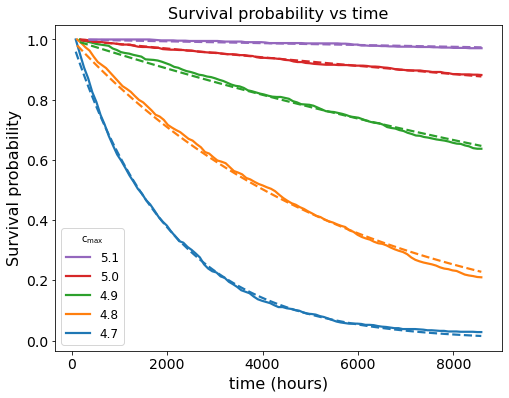

[9.99999844e-01 5.28689779e-04 1.00000000e+00]
[8.77028302e-03 5.59286767e-06 0.00000000e+00]

[9.99999962e-01 2.07872902e-04 1.00000000e+00]
[1.89237514e-03 6.12982964e-07 0.00000000e+00]

[9.99999988e-01 7.12357034e-05 1.00000000e+00]
[1.73600087e-03 3.98304982e-07 0.00000000e+00]

[9.99999996e-01 2.46073597e-05 1.00000000e+00]
[1.57804642e-03 3.25007344e-07 0.00000000e+00]

[9.99999999e-01 7.28657450e-06 1.00000000e+00]
[4.27098799e-04 8.38729359e-08 0.00000000e+00]



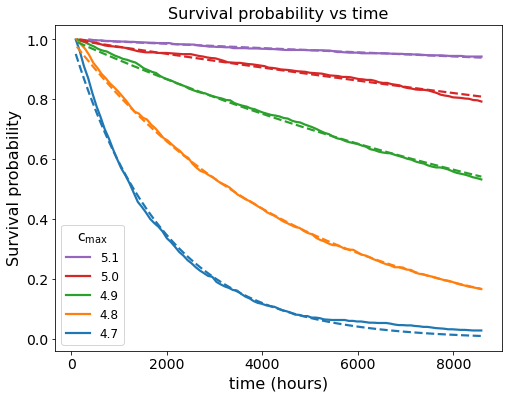

[9.99999873e-01 4.98422154e-04 1.00000000e+00]
[8.05283031e-03 4.85430199e-06 0.00000000e+00]

[9.99999959e-01 2.18844744e-04 1.00000000e+00]
[3.98495869e-03 1.31977738e-06 0.00000000e+00]

[9.99999985e-01 1.02405907e-04 1.00000000e+00]
[2.80375274e-03 6.95265024e-07 0.00000000e+00]

[9.99999994e-01 3.82574928e-05 1.00000000e+00]
[1.88412733e-03 3.99935129e-07 0.00000000e+00]

[9.99999997e-01 1.66475299e-05 1.00000000e+00]
[7.56139181e-04 1.53710406e-07 0.00000000e+00]



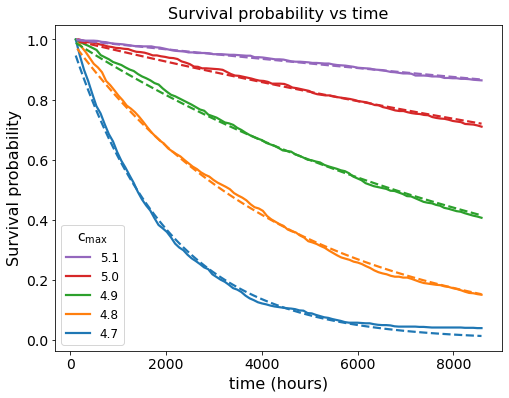

In [15]:
fitted_slopes_14pcres = fit_and_plot_survival_slope(ttf_14pcres, cmax_vals)
fitted_slopes_15pcres = fit_and_plot_survival_slope(ttf_15pcres, cmax_vals)
fitted_slopes_16pcres = fit_and_plot_survival_slope(ttf_16pcres, cmax_vals)

(0.0004887481828522084, 0.00017203029993036862, 5.080179585336945e-05, 1.5273611231592512e-05, 3.080763010880406e-06)
(2.4322127559376477e-06, 1.3306609701143944e-06, 5.134604456959312e-07, 1.1431522818888057e-07, 1.348778949877528e-07)
[0.004976412887601711, 0.007735038366223833, 0.010107131786796385, 0.0074844924658306515, 0.043780678523924504]
[0.001162323836485779, 0.005132789093800503, 0.02271144450823552, 0.05593923428774294, 1.6222586204765974]
[0.001162323836485779, 0.005132789093800503, 0.02271144450823552, 0.055939234287742945, 1.6222586204765974]


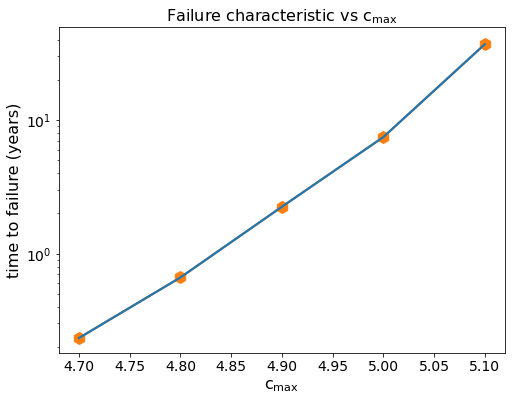

(0.000528689779336152, 0.0002078729021543778, 7.123570341986572e-05, 2.4607359673452937e-05, 7.286574502190985e-06)
(5.592867674708107e-06, 6.12982964149937e-07, 3.9830498176544586e-07, 3.250073437307402e-07, 8.38729358802662e-08)
[0.01057873235554275, 0.002948835359477025, 0.005591367286960338, 0.013207729234005004, 0.011510612545723182]
[0.0022841709751275927, 0.0016193791376722777, 0.008960168935309737, 0.06127157353432139, 0.18033121949896103]
[0.0022841709751275927, 0.0016193791376722777, 0.008960168935309737, 0.061271573534321375, 0.180331219498961]


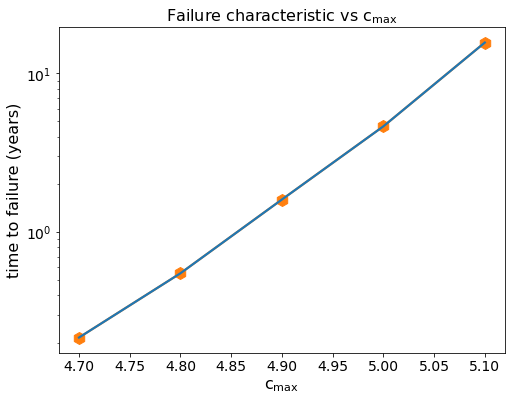

(0.0004984221538689378, 0.00021884474385931022, 0.00010240590726753553, 3.825749279558655e-05, 1.6647529907970837e-05)
(4.85430199231783e-06, 1.3197773757940219e-06, 6.952650239895821e-07, 3.9993512913726394e-07, 1.5371040606624013e-07)
[0.009739338339271111, 0.006030656037334273, 0.0067893058373400435, 0.010453772579247567, 0.009233226005056978]
[0.002230632417603966, 0.003145750920720257, 0.007568263722458721, 0.031192661801882335, 0.06331397145887256]
[0.002230632417603966, 0.0031457509207202567, 0.007568263722458721, 0.031192661801882328, 0.06331397145887256]


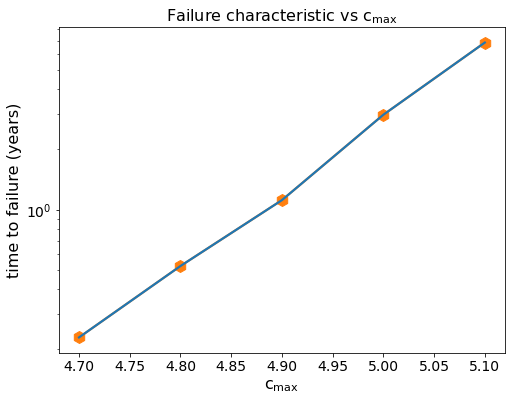

In [16]:
plot_characteristic_failure_rate(fitted_slopes_14pcres)
plot_characteristic_failure_rate(fitted_slopes_15pcres)
plot_characteristic_failure_rate(fitted_slopes_16pcres)